In [1]:
import os
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline
plt.jet()

<Figure size 432x288 with 0 Axes>

In [2]:
from lsst.obs.lsst.lsstCamMapper import LsstCamMapper
mapper = LsstCamMapper()
cam = mapper.camera

/var/folders/tr/bjzqy0h17kx31fhndw6050d80000gn/T/ipykernel_4003/1322787249.py:2: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  mapper = LsstCamMapper()


lsst.CameraMapper INFO: Loading Posix exposure registry from .


In [3]:
rnames = []
dnames = []
for det in cam:
    rname, dname = det.getName().split('_')
    if not rname in rnames:
        if not rname in ["R00", "R04", "R40", "R44"]:
            if not len(rname)>3:
                rnames.append(rname)
    if not dname in dnames:
        if "SG" in dname or "SW" in dname:   # ignore CR
            print(rname, dname)
            continue
        dnames.append(dname)
print('%d science rafts found'%len(rnames))
print('each rafts has %d CCDs'%len(dnames))

R00 SG0
R00 SG1
R00 SW0
R00 SW1
R04 SG0
R04 SG1
R04 SW0
R04 SW1
R40 SG0
R40 SG1
R40 SW0
R40 SW1
R44 SG0
R44 SG1
R44 SW0
R44 SW1
21 science rafts found
each rafts has 9 CCDs


In [4]:
def get_m5all(f):
    '''
    f is filter, can be u,g,r,i,z,y
    '''
    m5all = []
    m5vals = pd.read_csv('m5_output/m5df_13040.csv', index_col=0)
    for rname in rnames:
        for dname in dnames:
            key = rname+'_'+dname
            res = m5vals[key].apply(literal_eval)[f]
            for res1 in res:
                m5all.append(res1)
    #print('%s band, found %.0f rafts'%(f, len(m5all)/16/9))
    while -1 in m5all:
        #get rid of the dead channels, we account for them in fF.
        m5all.remove(-1)
    #print(sum([1 if ele<0 else 0 for ele in m5all]))
    return m5all

In [5]:
m5design = np.array([23.9, 25.0, 24.7, 24.0, 23.3, 22.1]) #SRD Table 6
m5min = np.array([23.4, 24.6, 24.3, 23.6, 22.9, 21.7])
#m52019 = np.array([23.74, 24.82, 24.37, 23.94, 23.36, 22.45])

#### Note: the SRD *median* in Tables 5 and 6 refers to median condition, not median over the devices. Since we are using fiducial atmosphere, this is already the median condition. Averaging over the devices is good enough for this purpose (by Zeljko), even though it doesn't project anything onto the time axis.
Table 7 is about variation over devices.

u
14% brighter than average-0.2 mag
4% brighter than average-0.4 mag
g
6% brighter than average-0.2 mag
2% brighter than average-0.4 mag
r
5% brighter than average-0.2 mag
1% brighter than average-0.4 mag
i
4% brighter than average-0.2 mag
1% brighter than average-0.4 mag
z
3% brighter than average-0.2 mag
1% brighter than average-0.4 mag
y
3% brighter than average-0.2 mag
1% brighter than average-0.4 mag


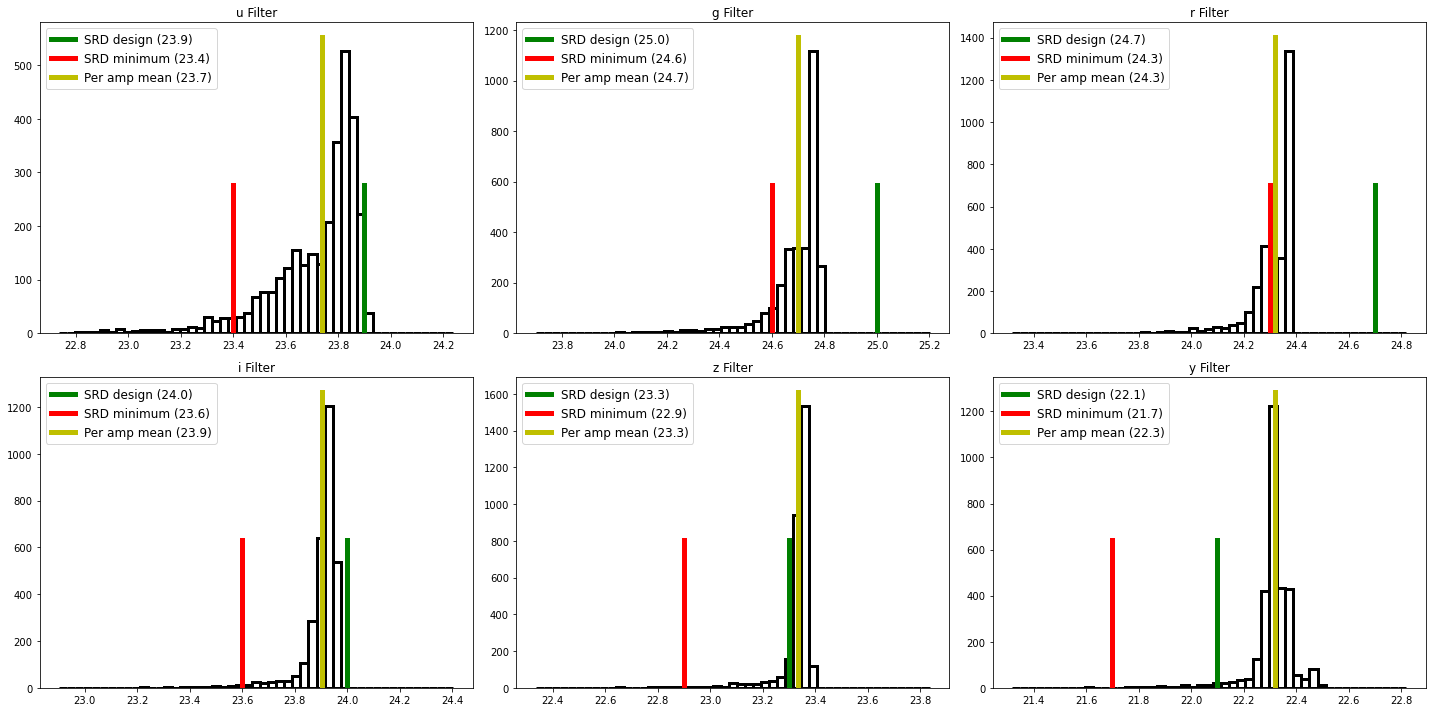

In [6]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
fig, ax = plt.subplots(2,3,figsize=(20,5*2))

mean_m5 = {}
for i,f in enumerate(filterlist):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    if f == 'u':
        m5 = np.array(get_m5all('u_30'))
    else:
        m5 = np.array(get_m5all(f))
    #SRD Table 7.
    mm5 = np.log10(np.mean(10**(0.8*(m5))))/0.8
    mean_m5[f] = mm5
    #break
    binlow = mm5-1
    binhigh = binlow+1.5
    bins = np.linspace(binlow, binhigh,50)
    ax[irow][icol].hist(m5, bins, fill=False, linewidth=3)
    (y1, y2) = (ax[irow][icol].get_ylim())
    ax[irow][icol].plot([m5design[i], m5design[i]],[y1, y2/2], linewidth=5, color='g', 
                        label=f'SRD design ({m5design[i]:.1f})')
    ax[irow][icol].plot([m5min[i], m5min[i]],[y1, y2/2], linewidth=5, color='r', 
                        label=f'SRD minimum ({m5min[i]:.1f})')
    #ax[irow][icol].plot([m52019[i], m52019[i]],[y1, y2], linewidth=5, color='b', label='Summer 2019')
    ax[irow][icol].plot([mm5, mm5],[y1, y2], linewidth=5, color='y', 
                        label=f'Per amp mean ({mm5:.1f})')
    #ax[irow][icol].text(0.85, 0.48, f, color = 'black', transform=ax[irow][icol].transAxes, fontsize=15)
    #ax[irow][icol].text(0.67, 0.28, '  design = %.1f\n       min = %.1f\naverage = %.1f'%(m5design[i], m5min[i], mm5), 
    #                    color = 'black', transform=ax[irow][icol].transAxes, fontsize=13)
    ax[irow][icol].legend(fancybox=True, numpoints=1, fontsize='large')
    ax[irow][icol].set_title(f'{f} Filter', fontsize='large')
    
    print(f)
    print('%.0f%% brighter than average-0.2 mag'%(sum(m5<mm5-0.2)/m5.shape[0]*100 ))
    print('%.0f%% brighter than average-0.4 mag'%(sum(m5<mm5-0.4)/m5.shape[0]*100 ))

plt.tight_layout()

In [7]:
pd.DataFrame(mean_m5, columns=filterlist, index=['mean m5'])

,u,g,r,i,z,y
mean m5,23.737928,24.700254,24.317683,23.903103,23.335777,22.31845


With regard to SRD Table 5, we are failing the design spec, but meets the minimum.

In [8]:
a=np.array(m5)

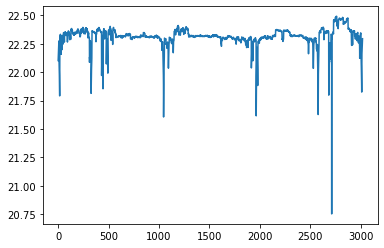

In [9]:
plt.plot(a)

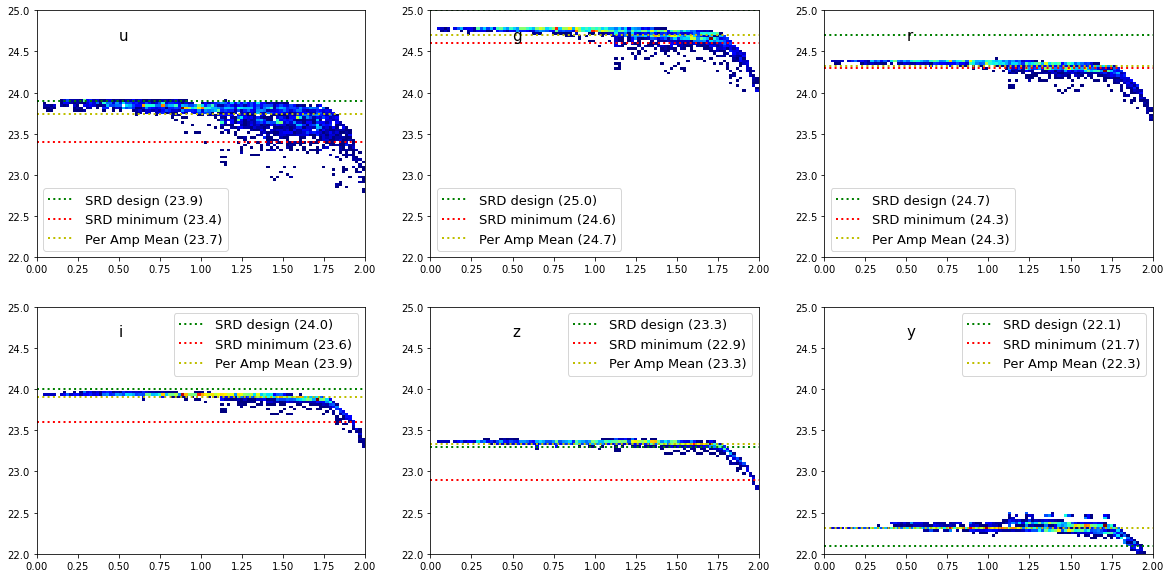

In [10]:
rad = []
effarea = []
rdnoise = []
s = 13040
dfPath = os.path.join('m5_output', f'adf_{s}.csv')
adf = pd.read_csv(dfPath, index_col=0)
# Join all the amp together into a big list for the whole focal plane
# Pick one of the m5 values to reformat like this too (so that we reject the same points)
dfPath = os.path.join('m5_output', f'm5df_{s}.csv')
df = pd.read_csv(dfPath, index_col=0)
for k in adf:
    rad += adf[k].apply(literal_eval)['radDeg']
    effarea += adf[k].apply(literal_eval)['effarea']
    rdnoise += adf[k].apply(literal_eval)['readnoise']


fig, ax = plt.subplots(2,3, figsize=(20,10))
for i,f in enumerate(filterlist):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    #print(f)
    m5 = []
    if f == 'u':
        kk = 'u_30'
    else:
        kk = f
    for k in df:
        m5 += df[k].apply(literal_eval)[kk]
    rad = np.array(rad)
    effarea = np.array(effarea)
    m5 = np.array(m5)
    mm5 = np.log10(np.mean(10**(0.8*(m5))))/0.8
    rdnoise = np.array(rdnoise)
    good = np.where((m5 > 20) & (rdnoise < 80))
    ax[irow][icol].plot([0,2],[m5design[i], m5design[i]], linewidth=2, color='g', linestyle=':',
                        label='SRD design (%.1f)'%m5design[i])
    ax[irow][icol].plot([0,2],[m5min[i], m5min[i]], linewidth=2, color='r', linestyle=':',
                        label='SRD minimum (%.1f)'%m5min[i])
    #ax[irow][icol].plot([0,2],[m52019[i], m52019[i]], linewidth=2, color='b', label='Summer 2019 = %.1f'%m52019[i])
    ax[irow][icol].plot([0,2],[mm5, mm5], linewidth=2, color='y', linestyle=':', 
                        label='Per Amp Mean (%.1f)'%mm5)
    ax[irow][icol].hist2d(rad[good], m5[good], range=[[0,2],[22, 25]], bins=100, cmin=1)
    ax[irow][icol].text(0.25, 0.88, f, color = 'black', transform=ax[irow][icol].transAxes, fontsize=15)
    if i<3:
        ax[irow][icol].legend(fontsize=13, loc='lower left')
    else:
        ax[irow][icol].legend(fontsize=13)